# Setup

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import re

import nltk 
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing.label import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the data

In [2]:
filelist = ['reuters-000.json',
            'reuters-001.json',
            'reuters-002.json',
            'reuters-003.json',
            'reuters-004.json',
            'reuters-005.json',
            'reuters-006.json',
            'reuters-007.json',
            'reuters-008.json',
            'reuters-009.json',
            'reuters-010.json',
            'reuters-011.json',
            'reuters-012.json',
            'reuters-013.json',
            'reuters-014.json',
            'reuters-015.json',
            'reuters-016.json',
            'reuters-017.json',
            'reuters-018.json',
            'reuters-019.json',
            'reuters-020.json',
            'reuters-021.json']
data_set = pd.DataFrame()
for fname in filelist:
  df = pd.read_json('data/reuters-21578-json/'+fname).T
  data_set = data_set.append(df)
  
data_set = data_set.fillna('')
print("Done!") 

Done!


In [3]:
data_set.head()

,title,body,date,topics,places,organisations
1,BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,26-FEB-1987 15:01:01.79,[cocoa],"[el-salvador, usa, uruguay]",
2,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...,26-FEB-1987 15:02:20.00,,[usa],
3,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...,26-FEB-1987 15:03:27.51,,[usa],
4,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...,26-FEB-1987 15:07:13.72,,"[usa, brazil]",
5,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...,26-FEB-1987 15:10:44.60,"[grain, wheat, corn, barley, oat, sorghum]",[usa],


In [4]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21578 entries, 1 to 21578
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          21578 non-null  object
 1   body           21578 non-null  object
 2   date           21578 non-null  object
 3   topics         21578 non-null  object
 4   places         21578 non-null  object
 5   organisations  21578 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


# Exploratory Data Analysis

Extracting metadata and the text bodyfrom each document in the corpus.

In [5]:
topics =set([x for sublist in data_set['topics'].values.tolist() for x in sublist])
places = set([x for sublist in data_set['places'].values.tolist() for x in sublist])
orgs = set([x for sublist in data_set['organisations'].values.tolist() for x in sublist])

In [6]:
data_set['topic_count']=data_set['topics'].apply(lambda x:len([y for y in x]))

#data_set['organisations'].apply(tuple).value_counts()[1:15].plot(kind='bar',title="Document Count by Organization")


In [7]:
print("documents with at least one topic = ",len(data_set[data_set['topic_count']>0]))
print("max number of topics in one document = ",data_set['topic_count'].max())
print('topics = ',len(topics))
print('places = ',len(places))
print('organizations = ',len(orgs))

documents with at least one topic =  11367
max number of topics in one document =  16
topics =  120
places =  147
organizations =  32


In [87]:
def plot_document_count(data_set, by='organisations', id_min=1, id_max=15, message='' ):
    docs = data_set[by].apply(tuple).value_counts()[id_min:id_max].reset_index()
    docs.rename(columns={'index':by, by:'Document Count'}, inplace=True)
    sns.barplot(x=by, y='Document Count', data=docs)
    plt.xticks(rotation=60)
    plt.title('Document Count by '+ by + ' ' +message)

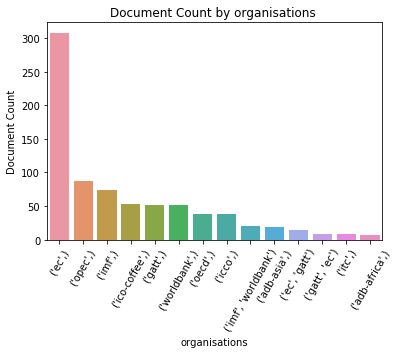

In [88]:
plot_document_count(data_set,by='organisations')

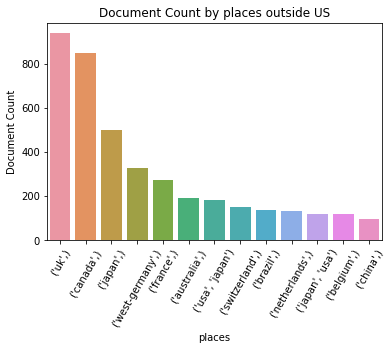

In [91]:
plot_document_count(data_set,by='places', id_min=2, id_max=15, message='outside US')

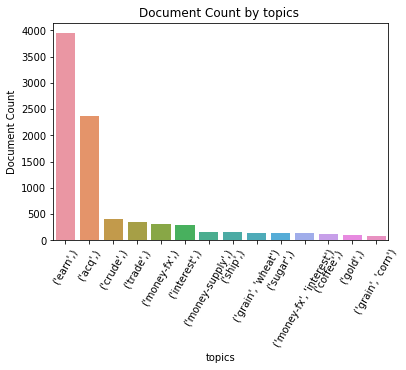

In [92]:
plot_document_count(data_set,by='topics', id_min=1, id_max=15)

# Text normalization

In [ ]:
nltk.download('punkt')
nltk.download('stopwords', 'data')
nltk.data.path.append('data')

In [ ]:
ml_binarizer = MultiLabelBinarizer()
data_target = ml_binarizer.fit_transform(data_set['topics'])

stopWords = stopwords.words('english')

charfilter = re.compile('[a-zA-Z]+');

def SimpleTokenizer(text):
    #tokenization
    words = map(lambda word: word.lower(), word_tokenize(text))
    #Remouve stop words
    words = [word for word in words if word not in stopWords]
    #Stemming (remove morphological affixes from tokens)
    tokens = (list(map(lambda token: PorterStemmer().stem(token),words)))
    ntokens = list(filter(lambda token:charfilter.match(token),tokens))
    return ntokens

vec = TfidfVectorizer(tokenizer=SimpleTokenizer,
                        max_features=1000,
                        norm='l2')

mytopics = ['cocoa','trade','money-supply','coffee','gold']
data_set = data_set[data_set['topics'].map(set(mytopics).intersection).apply(lambda x: len(x)>0)]
docs = list(data_set['body'].values)

dtm = vec.fit_transform(docs)

print("Number of documents with my topics = ",len(data_set))


# Text Clustering

In [ ]:
from sklearn.decomposition import PCA

explained_var = []
for components in range(1,100,5):
  pca = PCA(n_components=components)
  pca.fit(dtm.toarray())
  explained_var.append(pca.explained_variance_ratio_.sum())

plt.plot(range(1,100,5),explained_var,"ro")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Explained Variance")

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

components = 60

palette = np.array(sns.color_palette("hls", 120))

pca = PCA(n_components=components)
pca.fit(dtm.toarray())
pca_dtm = pca.transform(dtm.toarray())
data_target = ml_binarizer.fit_transform(data_set[u'topics'])
plt.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[data_target.argmax(axis=1).astype(int)])

explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(
    int(explained_variance * 100)))

In [ ]:
from sklearn.cluster import KMeans
palette = np.array(sns.color_palette("hls", 5))

model = KMeans(n_clusters=5,max_iter=100)
clustered = model.fit(pca_dtm)
centroids = model.cluster_centers_
y = model.predict(pca_dtm)

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[y.astype(np.int)])

In [ ]:
palette = np.array(sns.color_palette("hls", 5))

gold_labels = data_set['topics'].map(set(mytopics).intersection).apply(lambda x: x.pop()).apply(lambda x: mytopics.index(x))

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[gold_labels])

# Topic Modeling

In [ ]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

components = 60

palette = np.array(sns.color_palette("hls", 120))

lsa = TruncatedSVD(n_components=components)
lsa.fit(dtm)
lsa_dtm = lsa.transform(dtm)

plt.scatter(lsa_dtm[:,0],lsa_dtm[:,1],c=palette[data_target.argmax(axis=1).astype(int)])

explained_variance = lsa.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))